<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [24]</a>'.</span>

In [1]:
from dask.distributed import Client, LocalCluster
from dask import delayed, dataframe as dd
import dask
import pandas as pd
import geopandas as gpd
import math
import numpy as np
import momepy
import matplotlib.pyplot as plt
import contextily as ctx
from math import ceil
from shapely.geometry import box
from tqdm import tqdm

In [2]:
local_crs = 27700
place = "test"
lat = 55.86421405612109
lng = -4.251846930489373
country = "UK"
crs=4326
radius=1

In [3]:
# Parameters
local_crs = 27700
place = "Bristol_OS"
lat = 51.453611
lng = -2.5975
country = "UK"
crs = 4326
radius = 20


In [4]:
streets = gpd.read_parquet(f"../output/{place}/streets_raw.pq").explode().to_crs(local_crs).reset_index(drop=True)

buildings = gpd.read_parquet(f"../output/{place}/buildings_raw.pq").to_crs(local_crs)

study_area = gpd.read_parquet(f"../output/{place}/study_area.pq").to_crs(local_crs)

water = gpd.read_parquet(f"../output/{place}/water.pq").to_crs(local_crs)

rail = gpd.read_parquet(f"../output/{place}/rail_raw.pq").to_crs(local_crs).reset_index(drop=True)

/tmp/ipykernel_387761/1105020976.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  streets = gpd.read_parquet(f"../output/{place}/streets_raw.pq").explode().to_crs(local_crs).reset_index(drop=True)


In [5]:
daskCluster = LocalCluster(threads_per_worker=2,
                n_workers=8, memory_limit='70GB')

client = Client(daskCluster)

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 521.54 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38979,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 521.54 GiB
Comm: tcp://127.0.0.1:41339,Total threads: 2
Dashboard: http://127.0.0.1:42093/status,Memory: 65.19 GiB
Nanny: tcp://127.0.0.1:45931,


In [6]:
streets[~streets['geometry'].is_valid]

,geometry


In [7]:
buildings[~buildings['geometry'].is_valid]

,ID,geometry


In [8]:
water[~water['geometry'].is_valid]

,geometry


<Axes: >

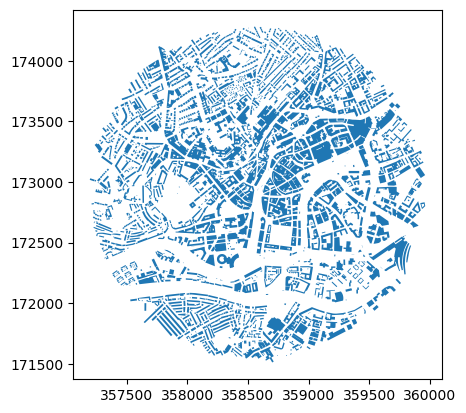

In [9]:
buildings.plot()

In [10]:
# buildings = momepy.preprocess(buildings.reset_index(), size=40,
#                               compactness=0.2, islands=True)

In [11]:
buildings

,ID,geometry
0,93A4A861-6CA0-4521-B8DB-AE213C50DB21,"POLYGON ((358583.194 172945.933, 358584.824 17..."
1,04BC651C-C00A-4597-A9EE-60D5E1DB8D0F,"POLYGON ((358621.804 172936.073, 358623.554 17..."
2,A4CC8115-F9EF-49E6-A511-373A8E1E441E,"POLYGON ((358613.824 172956.983, 358612.014 17..."
3,5693360C-112C-47DC-B343-8F4B8A6B7197,"POLYGON ((358678.914 172933.653, 358627.624 17..."
4,017E4DE2-291C-4B59-B079-458A701E6594,"POLYGON ((358630.614 172900.653, 358672.414 17..."
...,...,...
1995,84A081C9-E84E-4ED5-9922-DBF9C6D13748,"POLYGON ((358884.352 174250.134, 358894.592 17..."
1996,C8B74FAB-AF22-4166-926B-71DCD77C5B42,"POLYGON ((357198.663 173030.054, 357234.274 17..."
1997,926B47E6-6453-4B48-A991-1825F75B42D4,"POLYGON ((359730.115 172201.032, 359761.196 17..."
1998,CCEDEADF-63CA-42DF-B520-91DF949E4BE6,"POLYGON ((357281.443 173333.094, 357272.183 17..."


In [12]:
# Check for invalid geometries
invalid_geometries = buildings[~buildings.geometry.is_valid]

# If there are invalid geometries, attempt to fix them
if not invalid_geometries.empty:
    print(f"Found {len(invalid_geometries)} invalid geometries. Attempting to fix...")
    buildings.geometry = buildings.geometry.buffer(0)

    # Recheck for invalid geometries
    still_invalid = buildings[~buildings.geometry.is_valid]
    if still_invalid.empty:
        print("All invalid geometries fixed.")
    else:
        print(f"Could not fix {len(still_invalid)} geometries.")
else:
    print("No invalid geometries found.")

No invalid geometries found.


In [13]:
buildings['uID'] = momepy.unique_id(buildings)

In [14]:
water_bodies_boundaries = []

# Explode the GeoDataFrame into a GeoSeries of polygons and multipolygons
gs = water.explode()

# Convert each polygon into a MultiLineString
mls = gs.geometry.boundary

# Convert the MultiLineString into a DataFrame
water_bodies = gpd.GeoDataFrame({'geometry': mls})

for water_body in water_bodies.geometry:
    # Create a LineString object from the coordinates
    water_bodies_boundaries.append(water_body)

# # Create a GeoDataFrame of the water area boundaries
water_bodies_boundaries = gpd.GeoDataFrame({'geometry': water_bodies_boundaries}).reset_index(drop=True)

/tmp/ipykernel_387761/893087771.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gs = water.explode()


In [15]:
enclosures = momepy.enclosures(streets, limit=study_area, additional_barriers=[water_bodies_boundaries, rail])

/users/wjb22189/.conda/envs/momepy/lib/python3.11/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as OSGB36 / British National Grid (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))
/users/wjb22189/.conda/envs/momepy/lib/python3.11/site-packages/momepy/elements.py:1001: FutureWarning: The `query_bulk()` method is deprecated and will be removed in GeoPandas 1.0. You can use the `query()` method instead.
  inp, res = enclosures.sindex.query_bulk(


/users/wjb22189/.conda/envs/momepy/lib/python3.11/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as OSGB36 / British National Grid (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


In [16]:
num_chunks = ceil(len(buildings) / 1400000)

In [17]:
def split_bounds(bounds, num_chunks):
    minx, miny, maxx, maxy = bounds
    width = maxx - minx
    height = maxy - miny

    # Assuming a square grid for simplicity
    chunks_per_side = math.ceil(math.sqrt(num_chunks))
    chunk_width = width / chunks_per_side
    chunk_height = height / chunks_per_side

    chunks = []
    for i in range(chunks_per_side):
        for j in range(chunks_per_side):
            new_minx = minx + i * chunk_width
            new_miny = miny + j * chunk_height
            new_maxx = new_minx + chunk_width
            new_maxy = new_miny + chunk_height

            # Create a new bounding box (as a shapely box) for each chunk
            chunk_bounds = box(new_minx, new_miny, new_maxx, new_maxy)
            chunks.append(chunk_bounds)

    return gpd.GeoSeries(chunks)

# Example usage
chunks = split_bounds(enclosures.total_bounds, num_chunks)

In [18]:
chunks = gpd.GeoDataFrame(geometry = chunks)
chunks["chunk_ID"] = range(len(chunks))
enclosures["centroid"] = enclosures.centroid
enclosures = enclosures.sjoin(chunks, how="left")
enclosures = enclosures[["geometry", "chunk_ID", "eID"]]

/users/wjb22189/.conda/envs/momepy/lib/python3.11/site-packages/geopandas/geodataframe.py:2189: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


In [19]:
chunks

,geometry,chunk_ID
0,"POLYGON ((383579.488 147906.236, 383579.488 19...",0


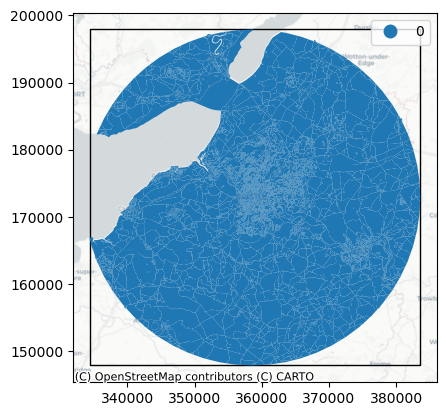

In [20]:
# Plotting each chunk
fig, ax = plt.subplots()
chunks.plot(ax=ax, edgecolor='black', facecolor='none')
enclosures.plot(ax=ax, column='chunk_ID', categorical=True, legend=True)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=buildings.crs)
plt.show()

In [21]:
buildings = buildings[["geometry"]].sjoin(enclosures, how="left")

In [22]:
buildings = buildings.dropna()[["geometry", "chunk_ID"]]
buildings["uID"] = range(len(buildings))
old_buildings = buildings
buildings = buildings.set_geometry('geometry')

In [23]:
buildings = buildings.to_crs(local_crs)
enclosures = enclosures.to_crs(local_crs)

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [24]:
tessellation = gpd.GeoDataFrame()

for index, chunk in tqdm(chunks.iterrows(), total= chunks.shape[0]):
    chunk_tessellation = momepy.Tessellation(buildings[buildings["chunk_ID"]==index], unique_id='uID', enclosures=enclosures[enclosures["chunk_ID"] == index], use_dask = True).tessellation
    tessellation = pd.concat([tessellation, chunk_tessellation])
    
tessellation_old = tessellation

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

GEOSException: IllegalArgumentException: Points of LinearRing do not form a closed linestring

In [ ]:
# tessellation.plot()

In [ ]:
tessellation = tessellation_old

In [ ]:
tessellation.to_parquet(f"../output/{place}/tessellation_p1_raw.pq")

In [ ]:
# tessellation = gpd.read_parquet(f"../output/{place}/tessellation_p1_raw.pq")

In [ ]:
tessellation=tessellation.sort_values(by='uID').reset_index(drop=True).dropna(subset=['uID'])

In [ ]:
duplicate_gdf = tessellation[tessellation.duplicated('uID', keep=False)]

In [ ]:
@delayed
def find_valid_from_multiples(gdf, building):
    gdf = gdf[gdf.intersects(building)]
        
    if gdf.shape[0] > 1:
        smallest_area = gdf.geometry.area.idxmin()
        return gdf.loc[[smallest_area]]
    return gdf

# Using a list comprehension for conciseness and efficiency
results = dask.compute([
    find_valid_from_multiples(duplicate_gdf[duplicate_gdf['uID'] == uid].reset_index(), buildings[buildings["uID"] == uid].geometry.iloc[0])
    for uid in duplicate_gdf["uID"].unique()
])

# Concatenate the results into a single GeoDataFrame
a = gpd.GeoDataFrame(pd.concat(results[0], ignore_index=True))
tessellation = gpd.GeoDataFrame(pd.concat([tessellation, a], ignore_index=True))


In [ ]:
tessellation

In [ ]:
tessellation = tessellation.drop("eID", axis = 1)

In [ ]:
# Convert the 'uID' column of buildings to a set for efficient lookups
uIDs_buildings = set(buildings['uID'])

# Filter the tesellation GeoDataFrame to keep only rows with uID in buildings
tessellation = tessellation[tessellation['uID'].isin(uIDs_buildings)]


In [ ]:
# Convert the 'uID' column of buildings to a set for efficient lookups
uIDs_tessellation = set(tessellation['uID'])

# Filter the tesellation GeoDataFrame to keep only rows with uID in buildings
buildings = buildings[buildings['uID'].isin(uIDs_tessellation)]


In [ ]:
tessellation

In [ ]:
tessellation = tessellation[["uID", "geometry"]]
buildings = buildings[["uID", "geometry"]]

In [ ]:
tessellation[tessellation.duplicated('uID', keep=False)]

In [ ]:
combined = tessellation.merge(buildings, on='uID', how='inner').reset_index()
combined["uID"] = range(len(combined))
combined

In [ ]:
tessellation = gpd.GeoDataFrame(combined[["uID", "geometry_x"]], geometry='geometry_x')
tessellation = tessellation.rename(columns={'geometry_x': 'geometry'})

In [ ]:
tessellation = tessellation.set_geometry("geometry", crs=local_crs)

In [ ]:
buildings = gpd.GeoDataFrame(combined[["uID", "geometry_y"]], geometry='geometry_y')
buildings = buildings.rename(columns={'geometry_y': 'geometry'})

In [ ]:
buildings = buildings.set_geometry("geometry", crs=local_crs)

In [ ]:
tessellation.to_parquet(f"../output/{place}/tessellation_p2.pq")

In [ ]:
buildings.to_parquet(f"../output/{place}/buildings_p2.pq")

In [ ]:
streets.to_parquet(f"../output/{place}/streets_p2.pq")

In [ ]:
# # Create a figure and axis

# # Plot streets in blue on the same axis
# streets.plot(ax=ax, color='blue')

# # Plot buildings in red on the same axis
# buildings.plot(ax=ax, color='red')

# tessellation.plot(ax = ax, color = 'green')

# # Show the plot
# plt.show()